In [2]:
import pandas as pd
import spacy
from spacy.training import Example
import random
import json

## Intent Classifier

### Rule-based Approach

In [10]:
with open('../data/raw/rule_based_intents.json', 'r') as file:
    data = json.load(file)

rows = []
for intent, content in data.items():
    patterns = ", ".join(content['patterns'])
    responses = ", ".join(content['responses'])
    rows.append([intent, patterns, responses])

df = pd.DataFrame(rows, columns=['Intent', 'Patterns', 'Responses'])
pd.set_option('display.max_colwidth', None)
df.head(5)

,Intent,Patterns,Responses
0,greeting,"hello, hi, good morning, good afternoon, hey, greetings","Hello! How can I assist you today?, Hi there! What can I do for you?"
1,farewell,"bye, goodbye, see you, take care, farewell","Goodbye! Have a great day!, See you later! Take care!"
2,thanksgiving,"thank you, thanks, appreciate it, grateful","You're welcome!, Glad I could help!"
3,chatbot_identity,"who are you, what are you, tell me about yourself, what is this, who am I talking to, what's your name","I am StudentDesk, your university chatbot. I'm here to assist you with any queries., I'm StudentDesk, your virtual assistant for university-related tasks."
4,chatbot_creation,"who created you, who made you, who developed you, who built you, what's your origin","I was created by the university's development team to assist students like you., The university's IT team developed me to help answer your questions and simplify student services."


In [14]:
rows = []
for intent, content in data.items():
    pattern_count = len(content['patterns'])
    response_count = len(content['responses'])
    rows.append([intent, pattern_count, response_count])

df = pd.DataFrame(rows, columns=['Intent', 'Pattern Count', 'Response Count'])

df.head(5)

,Intent,Pattern Count,Response Count
0,greeting,6,2
1,farewell,5,2
2,thanksgiving,4,2
3,chatbot_identity,6,2
4,chatbot_creation,5,2


### LSTM

In [14]:
df = pd.read_csv('../data/raw/chatbot_dataset.csv')

df['processed_text'] = df['text'].str.lower()

len(df)

2000

In [15]:
df.head(5)

,text,intent,processed_text
0,"Please, change my first name to Carol",change_first_name,"please, change my first name to carol"
1,"Please, change my first name to Emma",change_first_name,"please, change my first name to emma"
2,I would like my first name to be Liam,change_first_name,i would like my first name to be liam
3,Change my first name to Mia,change_first_name,change my first name to mia
4,Can you update my first name to Noah?,change_first_name,can you update my first name to noah?


In [16]:
grouped = df.groupby('intent')
intent_counts = grouped.size().reset_index(name='count')
intent_counts

,intent,count
0,change_address,250
1,change_first_name,250
2,change_last_name,250
3,deregister_exam,250
4,query_exam_grade,250
5,query_exam_status,250
6,query_student_profile,250
7,register_exam,250


### Training Model

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns

tf.random.set_seed(42)
np.random.seed(42)

df = pd.read_csv('../data/raw/chatbot_dataset.csv')

# Preprocessing text 
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Encoding (convert text labels into numeric labels)
label_encoder = LabelEncoder()
y_intent = label_encoder.fit_transform(df['intent'])

# Splitting dataset into 80% for training and 20% for testing
X_train_intent, X_test_intent, y_train_intent, y_test_intent = train_test_split(
    df['processed_text'], y_intent, test_size=0.2, random_state=42
)

# breaking down a piece of text into tokens with special token - out-of-vocabulary
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_intent)

vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max(len(seq) for seq in tokenizer.texts_to_sequences(X_train_intent))

# converting into a sequence of integers using a tokenizer
X_train_seq = tokenizer.texts_to_sequences(X_train_intent)
X_test_seq = tokenizer.texts_to_sequences(X_test_intent)

# padding
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

# converting to vectors for multi-class classification
y_train_categorical = to_categorical(y_train_intent)
y_test_categorical = to_categorical(y_test_intent)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length),
    Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)),
    Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)

history = model.fit(
    X_train_padded, y_train_categorical,
    epochs=30, batch_size=32,
    validation_data=(X_test_padded, y_test_categorical),
    callbacks=[early_stopping]
)

model.save('../models/intent_lstm_model.keras')
with open('../models/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
with open('../models/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

/Users/amilbek/miniforge3/envs/trends-of-ai-semester-project/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1871 - loss: 2.7773 - val_accuracy: 0.4075 - val_loss: 1.7029
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4956 - loss: 1.5130 - val_accuracy: 0.7700 - val_loss: 0.8841
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8488 - loss: 0.7330 - val_accuracy: 0.9850 - val_loss: 0.3208
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9742 - loss: 0.3204 - val_accuracy: 0.9825 - val_loss: 0.2503
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9921 - loss: 0.2184 - val_accuracy: 0.9650 - val_loss: 0.2349
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9786 - loss: 0.2136 - val_accuracy: 0.9800 - val_loss: 0.1671
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9950 - loss: 0.1344 - val_accuracy: 0.9875 - val_loss: 0.1476
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9989 - loss: 0.0952 - val_accuracy: 0.9875 - v

### Metrics

Accuracy, Precision, Recall, F1-score

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

loss, accuracy = model.evaluate(X_test_padded, y_test_categorical)

y_pred_prob = model.predict(X_test_padded)
y_pred = y_pred_prob.argmax(axis=1)

precision = precision_score(y_test_intent, y_pred, average='weighted')
recall = recall_score(y_test_intent, y_pred, average='weighted')
f1 = f1_score(y_test_intent, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9946 - loss: 0.0635
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Accuracy: 99.50%
Precision: 99.51%
Recall: 99.50%
F1-score: 99.50%


### Classification Report

In [21]:
y_pred_prob = model.predict(X_test_padded)

y_pred = y_pred_prob.argmax(axis=1)

y_true = y_test_intent

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Classification Report:
                       precision    recall  f1-score   support

       change_address       1.00      1.00      1.00        50
    change_first_name       1.00      0.98      0.99        47
     change_last_name       1.00      1.00      1.00        57
      deregister_exam       0.98      1.00      0.99        41
     query_exam_grade       1.00      1.00      1.00        62
    query_exam_status       1.00      1.00      1.00        47
query_student_profile       0.98      1.00      0.99        51
        register_exam       1.00      0.98      0.99        45

             accuracy                           0.99       400
            macro avg       0.99      0.99      0.99       400
         weighted avg       1.00      0.99      0.99       400



### Intent Classifier Model Accuracy

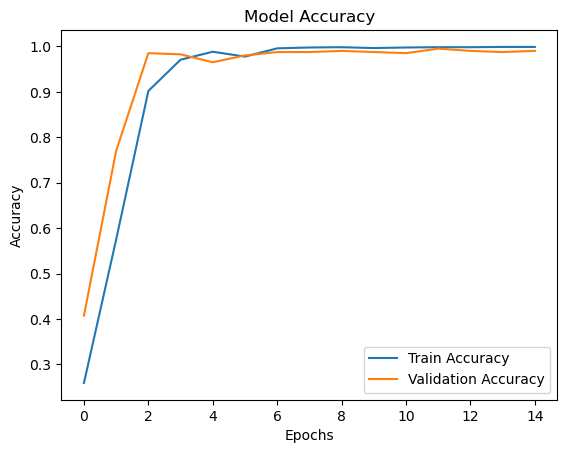

In [22]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

### Intent Classifier Model Confusion Matrix

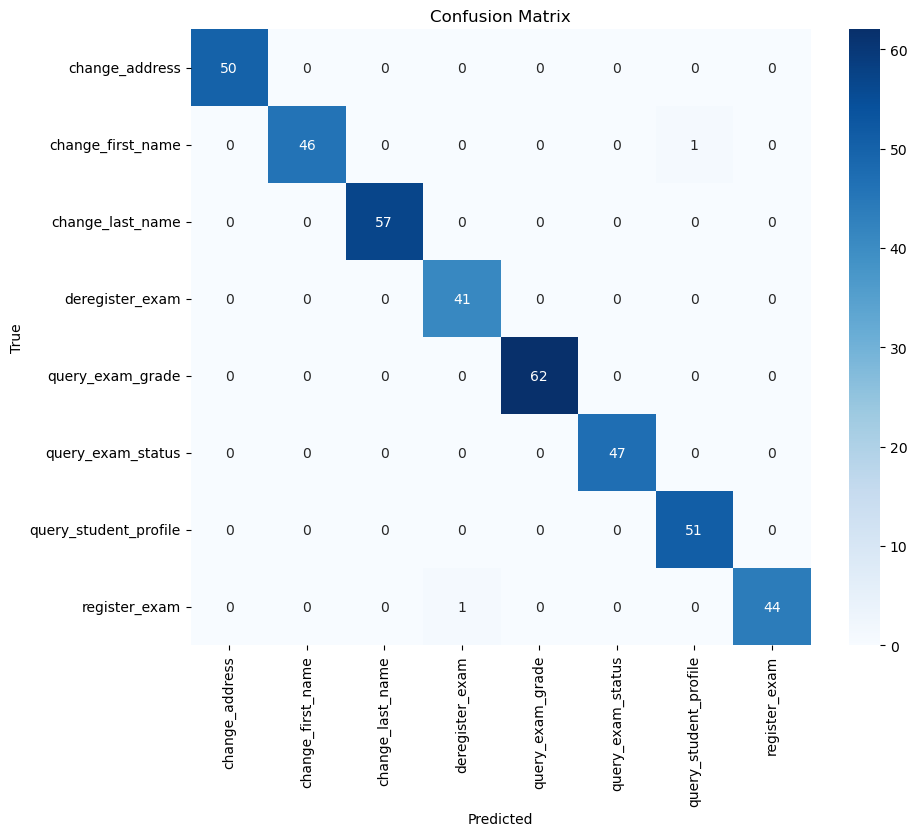

In [24]:
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Named Entity Recognition

In [7]:
df = pd.read_csv('../data/raw/tokens.csv')
print(f"Length: {len(df)}")
df.head()

Length: 1078


,text,entities
0,Please change my first name to Carol and my last name to Wilson.,Carol:first_name;Wilson:last_name
1,Change my first name to John and my last name to Smith.,John:first_name;Smith:last_name
2,Set my first name as Emma and my last name as Brown.,Emma:first_name;Brown:last_name
3,Update my first name to Hans and my last name to Müller.,Hans:first_name;Müller:last_name
4,I would like to change my first name to Maria and my last name to Schulz.,Maria:first_name;Schulz:last_name


In [10]:
def extract_entities(entities_str):
    entities = []
    for pair in entities_str.split(";"):
        value, label = pair.split(":")
        entities.append(label) 
    return entities

entity_labels = df['entities'].apply(extract_entities)

all_labels = [label for sublist in entity_labels for label in sublist]

entity_counts = pd.Series(all_labels).value_counts()


entity_counts_df = entity_counts.reset_index()
entity_counts_df.columns = ['Entity Label', 'Count']
entity_counts_df

,Entity Label,Count
0,matriculation_number,452
1,course_name,452
2,first_name,300
3,last_name,300
4,address,300
5,city,300
6,post_code,300


#### Parsing Entities into NER format

Converting plain text to NER required format:

Plain text

text – "Please change my first name to Carol and my last name to Wilson.", intent – "Carol:first_name;Wilson:last_name"

Converting

("Please change my first name to Carol and my last name to Wilson.", {'entities': [(31, 36, 'first_name'), (57, 63, 'last_name')]})

In [4]:
def parse_entities(entities_str, text):
    entities = []
    for pair in entities_str.split(";"):
        value, label = pair.split(":")
        start = text.find(value)
        if start != -1:
            end = start + len(value)
            entities.append((start, end, label))
    return {"entities": entities}

### Training Model

In [59]:
TRAIN_DATA = []
for _, row in df.iterrows():
    text = row['text']
    annotations = parse_entities(row['entities'], text)
    TRAIN_DATA.append((text, annotations))

nlp = spacy.load("de_core_news_lg")
ner = nlp.get_pipe("ner")

for _, annotations in TRAIN_DATA:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])

with nlp.disable_pipes([pipe for pipe in nlp.pipe_names if pipe != "ner"]):
    optimizer = nlp.create_optimizer()
    for iteration in range(200):
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in TRAIN_DATA:
            example = Example.from_dict(nlp.make_doc(text), annotations)
            nlp.update([example], losses=losses)
        print(f"Iteration {iteration + 1}: {losses}")

nlp.to_disk("../models/custom_ner_model")
print("Model saved to custom_ner_model")

/Users/amilbek/miniforge3/envs/trends-of-ai-semester-project/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I’d like to drop out of Theoretical Physics, under..." with entities "[(67, 74, 'matriculation_number'), (24, 43, 'cours...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/amilbek/miniforge3/envs/trends-of-ai-semester-project/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Register me for Environmental Policy Analysis, wit..." with entities "[(73, 80, 'matriculation_number'), (16, 45, 'cours...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/amilbek/minif

Iteration 1: {'ner': 405.97728318023024}
Iteration 2: {'ner': 33.80402354297698}
Iteration 3: {'ner': 47.281128889235696}
Iteration 4: {'ner': 26.40700387140202}
Iteration 5: {'ner': 41.69034313880697}
Iteration 6: {'ner': 27.830659606007448}
Iteration 7: {'ner': 61.85839626530216}
Iteration 8: {'ner': 27.306813877400238}
Iteration 9: {'ner': 13.014092694725079}
Iteration 10: {'ner': 27.273619212647592}
Iteration 11: {'ner': 47.012359945095504}
Iteration 12: {'ner': 33.62463367971498}
Iteration 13: {'ner': 12.867879922738119}
Iteration 14: {'ner': 16.947536414966496}
Iteration 15: {'ner': 21.105108173321184}
Iteration 16: {'ner': 18.130149368160538}
Iteration 17: {'ner': 11.723304032364632}
Iteration 18: {'ner': 21.283814080568334}
Iteration 19: {'ner': 16.275143860231942}
Iteration 20: {'ner': 6.214353142002337}
Iteration 21: {'ner': 11.477572073182607}
Iteration 22: {'ner': 36.73311570422687}
Iteration 23: {'ner': 11.930512363145569}
Iteration 24: {'ner': 22.24448449848237}
Iteration

### Detection of Overlapping Entities

Detecting: 

"Please change my address to Dortmunder 12, 44143 Dortmund" 

due to:

Dortmunder 12:address;Dortmund:city;44143:post_code

duplicate of - Dortmund

In [61]:
def detect_overlapping_entities(entities):
    overlaps = []
    sorted_entities = sorted(entities, key=lambda x: x[0])  

    for i in range(len(sorted_entities) - 1):
        start1, end1, label1 = sorted_entities[i]
        start2, end2, label2 = sorted_entities[i + 1]

        if start2 < end1: 
            overlaps.append(((start1, end1, label1), (start2, end2, label2)))

    return overlaps

overlapping_entities_log = []

for index, row in df.iterrows():
    text = row['text']
    annotations = parse_entities(row['entities'], text)
    
    overlaps = detect_overlapping_entities(annotations["entities"])
    
    if overlaps:
        overlapping_entities_log.append({"index": index, "text": text, "overlaps": overlaps})

for entry in overlapping_entities_log:
    print(f"Row {entry['index']}: {entry['text']}")
    for overlap in entry['overlaps']:
        print(f"  Overlapping Entities: {overlap}")

with open('../raw/overlapping_entities_log.json', 'w') as file:
    json.dump(overlapping_entities_log, file, indent=4)

print(f"Total rows with overlapping entities: {len(overlapping_entities_log)}")

Total rows with overlapping entities: 0


### Metrics
Precision, Recall, F1-score

Using of testing dataset

In [26]:
from spacy.scorer import Scorer

test_df = pd.read_csv('../data/raw/test_tokens.csv')

TEST_DATA = []
for _, row in test_df.iterrows():
    text = row['text']
    annotations = parse_entities(row['entities'], text)
    TEST_DATA.append((text, annotations))

nlp = spacy.load("../models/custom_ner_model")

test_spacy_examples = []
for text, annotations in TEST_DATA:
    doc = nlp(text)
    example = Example.from_dict(doc, annotations)
    test_spacy_examples.append(example)

scorer = Scorer()
results = scorer.score(test_spacy_examples)

precision = results["ents_p"]
recall = results["ents_r"]
f1_score = results["ents_f"]

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")

/Users/amilbek/miniforge3/envs/trends-of-ai-semester-project/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Please update my city to Munich and my post code t..." with entities "[(25, 31, 'city'), (52, 57, 'post_code')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/amilbek/miniforge3/envs/trends-of-ai-semester-project/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Please remove my registration from the exam in Dat..." with entities "[(82, 89, 'matriculation_number'), (47, 59, 'cours...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/amilbek/miniforge3/envs/t

Precision: 98.96%
Recall: 98.45%
F1-score: 98.70%


### Examples

In [28]:
from spacy import displacy

for text, annotations in TEST_DATA[:3]:
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)
    print(f"Predicted Entities: {[(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}")
    print(f"Actual Entities: {annotations['entities']}")

Predicted Entities: [('Kurfürstenstraße 20', 21, 40, 'address'), ('10785', 42, 47, 'post_code'), ('Berlin', 48, 54, 'city')]
Actual Entities: [(21, 40, 'address'), (48, 54, 'city'), (42, 47, 'post_code')]


Predicted Entities: [('Munich', 25, 31, 'city'), ('80331.', 52, 58, 'matriculation_number')]
Actual Entities: [(25, 31, 'city'), (52, 57, 'post_code')]


Predicted Entities: [('Michael', 26, 33, 'first_name'), ('Smith', 34, 39, 'last_name')]
Actual Entities: [(26, 33, 'first_name'), (34, 39, 'last_name')]
